**Introduction**
This is actually my first public kernel, so i hope it will be useful for someone.

Before you read the notebook, it is immportant to know that this notebook is a compilation of already existing notebooks and some model modifications
Here is list of notebooks:
* Data analysis - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
* Image conversion, Network architecture - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d
* Some ideas - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
* Code for conversion to image provided by MadScientist but i don't know which kernel it is.

Before running the model it is good idea to run thgrough kernels mentioned here and upvote them.

**Comments**
I've executed this code on my machine with 1080 TI and it may be pretty slow if you have low-end GPU or CPU

It is also important that i don't know how to execute code in the notebook with GPU, since keras is not freeing memory after model training, so train results here may be uncomplete.

I am also not sure about random seed initialization and haven't checked it, so maybe your results may differ from mine.

I am also sorry for a WinAPI style functions with 10+ arguments, but this solutin was made less than in a one day and basically my second solution. If someone is able to rewrite it in a normal style i will appreciate that, so feel free to fork and rewrite.

In [1]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
tf.set_random_seed(683)
# Uncomment this to hide TF warnings about allocation
#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

# Any results you write to the current directory are saved as output.

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


First of all, some data preprocessing is required.

The basic idea is that images, that provided in a dataset are very noisy and if we will get rid of granular noise, we will be able to predict better and construct noisy dataset by our own.

It is also interesting to train a denoising autoencoder on dataset in order to extract some global features that may be used further on model training.

In [2]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))
        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [3]:
train = pd.read_json("../train/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and 
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True and train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [4]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    #images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    return y, band, images

In [5]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


Plotting some random images to check how cleaning works

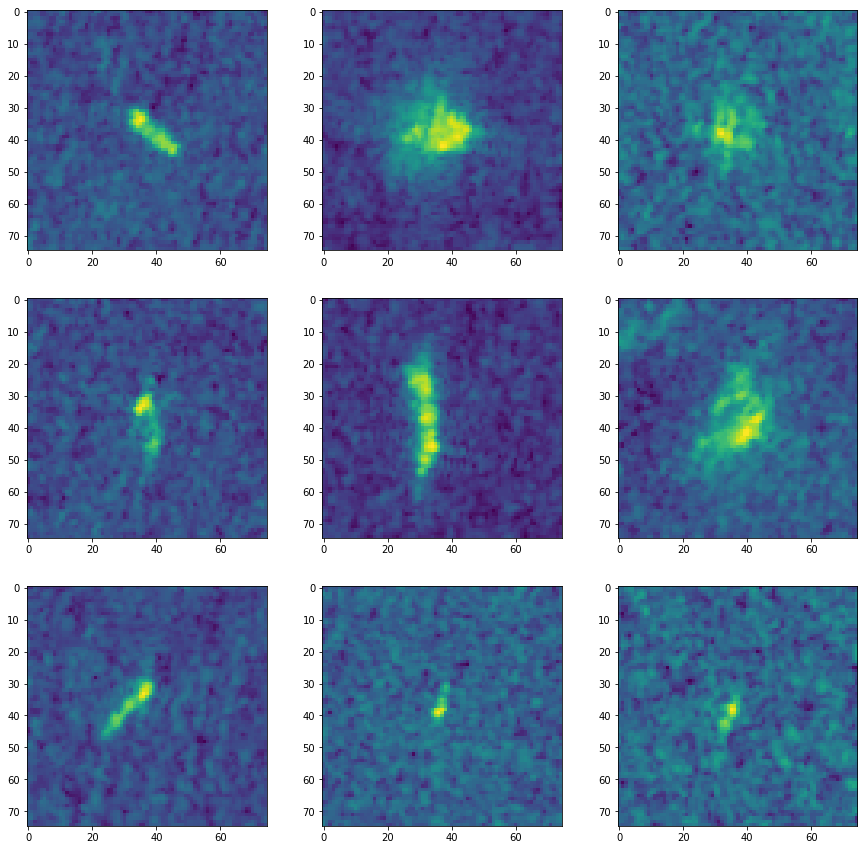

In [10]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
col_subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

In [12]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
org_subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
#for i in range(9):
#    ax = fig.add_subplot(3, 3, i + 1)
#    ax.imshow(subset[i])
#plt.show()

In [13]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
den_subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
#for i in range(9):
#    ax = fig.add_subplot(3, 3, i + 1)
#    ax.imshow(subset[i])
#plt.show()

In [14]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
smt_subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
#for i in range(9):
#    ax = fig.add_subplot(3, 3, i + 1)
#    ax.imshow(subset[i])
#plt.show()

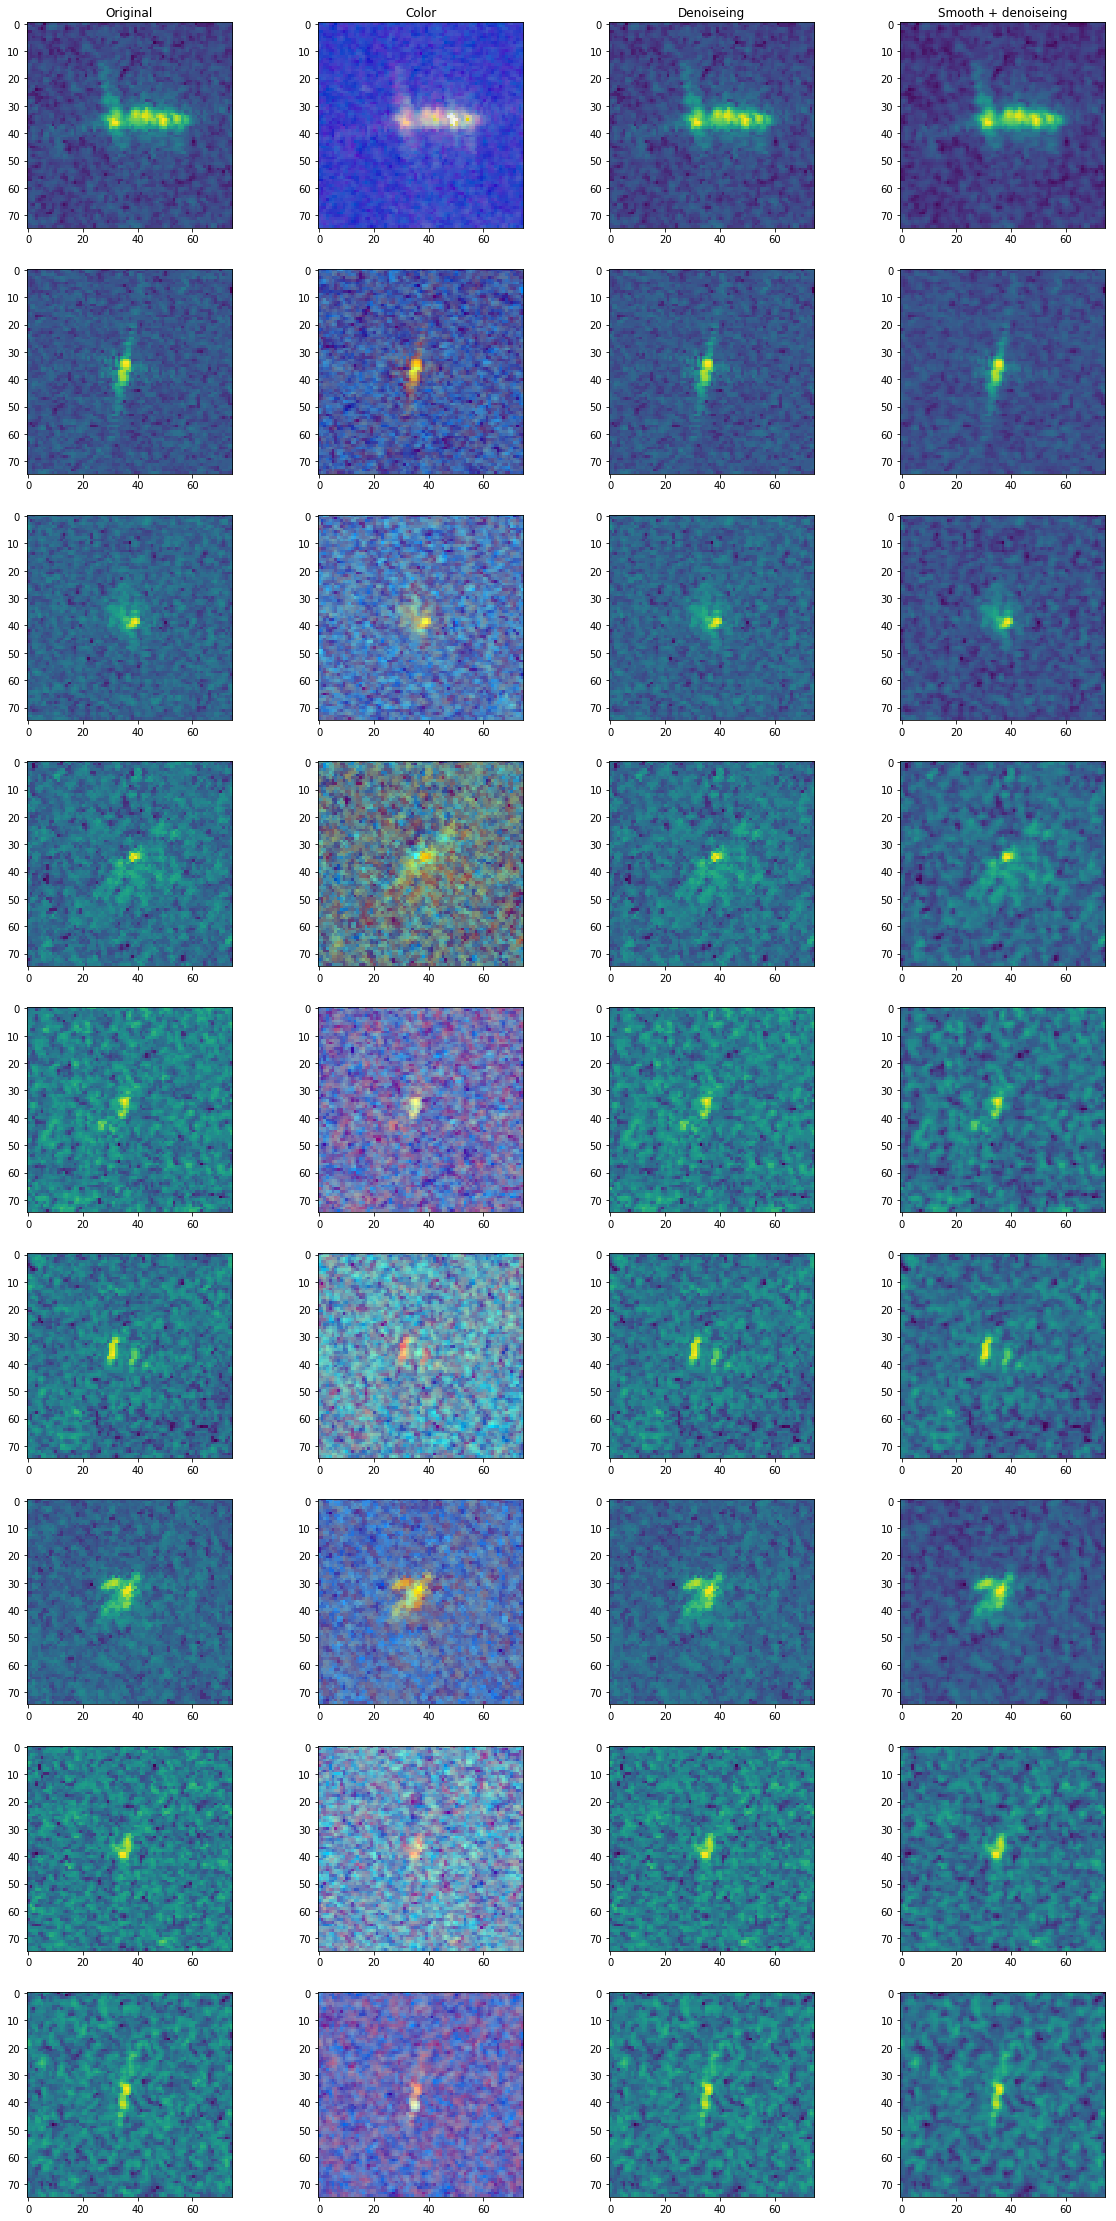

In [26]:
fig = plt.figure(300, figsize=(20, 40))

for i in range(9):
    ax = fig.add_subplot(9, 4, i*4 + 1)
    ax.imshow(org_subset[i])
    if i == 0: plt.title('Original')
    ax = fig.add_subplot(9, 4, i*4 + 2)
    ax.imshow(col_subset[i])
    if i == 0: plt.title('Color')
    ax = fig.add_subplot(9, 4, i*4 + 3)
    ax.imshow(den_subset[i])
    if i == 0: plt.title('Denoiseing')
    ax = fig.add_subplot(9, 4, i*4 + 4)
    ax.imshow(smt_subset[i])
    if i == 0: plt.title('Smooth + denoiseing')
        
plt.show()

**A few words about model**

The model itself consists of 3 convolutional neural networks.
Two basic networks and one combined. The idea is to train two basic networks on different data representations and after that, using trained convolutional layers in combination to train common network.

Architecture for these networks is taken from notebook mentioned in the vere beginning.

For training i'm using 3 datasets, 1 that network sees only once and default keras val split for model selection.

In [27]:
def get_model_notebook(lr, decay, channels, relu_type='relu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason i've decided not to normalize angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    optimizer = Adam(lr=lr, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model, partial_model


In [28]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    #for layer in m_b.layers:
    #    layer.trainable = False
    #for layer in m_img.layers:
    #    layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation="sigmoid")(common)
    model = Model([input_b, input_img], output)
    optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [29]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.,
                             height_shift_range=0.,
                             channel_shift_range=0,
                             zoom_range=0.2,
                             rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        I1i = genI1.next()
        I2i = genI2.next()
        #print I1i[0].shape
        np.testing.assert_array_equal(I2i[0], I1i[0])
        yield [I1i[0], I2i[1]], I1i[1]

In [30]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.,
                                   height_shift_range=0.,
                                   channel_shift_range=0,
                                   zoom_range=0.2,
                                   rotation_range=10)
    x_test, y_test = val_data
    try:
        model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                                    steps_per_epoch=len(X_train) / batch_size,
                                    validation_data=(x_test, y_test), verbose=1,
                                    callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name)
    return model

In [31]:
#Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                           X_train, y_train, (X_test, y_test), verbose=verbose)

    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                               verbose=0, batch_size=batch_size)

        loss_train, acc_train = model.evaluate(X_test, y_test,
                                       verbose=0, batch_size=batch_size)

        print('Val/Train Loss:', str(loss_val) + '/' + str(loss_train), \
            'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    return model, partial_model

In [32]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val,\
    X_b_full, X_b_val,\
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train_full, X_b_full, X_images_full, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print('Training bandwidth network')
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)

    if train_img:
        if verbose > 0:
            print('Training image network')
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                       data_images, verbose=verbose)

    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print('Training common network')
        callbacks = [ModelCheckpoint('common', save_best_only=True, monitor='val_loss')]
        try:
            common_model.fit_generator(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                         epochs=max_epoch,
                                  steps_per_epoch=len(X_b_full) / batch_size,
                                  validation_data=(common_x_val, common_y_val), verbose=1,
                                  callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        common_model.load_weights(filepath='common')
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                           verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                  verbose=0, batch_size=batch_size)
        if verbose > 0:
            print('Loss:', loss_val, 'Acc:', acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

Model parameters that are used in training assumes that you have enough computational power to process all the data.

(Don't know if it is obvious or not) The important moment here is to save 3 sets, since if you are selecting model based on a validation set it affects final performance since it causes inderect observations of validation set and affect final evaluation score.

In [33]:
# Best parameters i got are
# epochs : 250
# learning rate : 8e-5
# batch size : 32
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Training bandwidth network
Epoch 1/50
39/38 [==============================] - 23s 598ms/step - loss: 0.6748 - acc: 0.5744 - val_loss: 3.1588 - val_acc: 0.5253
Epoch 2/50
39/38 [==============================] - 23s 577ms/step - loss: 0.6063 - acc: 0.6238 - val_loss: 2.6053 - val_acc: 0.5253
Epoch 3/50
39/38 [==============================] - 24s 617ms/step - loss: 0.6025 - acc: 0.6591 - val_loss: 0.7138 - val_acc: 0.5346
Epoch 4/50
39/38 [==============================] - 25s 647ms/step - loss: 0.5568 - acc: 0.6766 - val_loss: 0.6808 - val_acc: 0.5346
Epoch 5/50
39/38 [==============================] - 29s 738ms/step - loss: 0.5384 - acc: 0.7077 - val_loss: 0.6208 - val_acc: 0.6129
Epoch 6/50
39/38 [==============================] - 22s 572ms/step - loss: 0.4890 - acc: 0.7545 - val_loss: 0.6636 - val_acc: 0.5346
Epoch 7/50
39/38 [==============================] - 26s 674ms/step - loss: 0.4797 - acc: 0.7737 - val_loss: 0.5978 - val_acc: 0.6959
Epoch 8/50
39/38 [========================

39/38 [==============================] - 25s 653ms/step - loss: 0.4176 - acc: 0.7971 - val_loss: 0.5397 - val_acc: 0.7235
Epoch 12/50
39/38 [==============================] - 24s 619ms/step - loss: 0.3874 - acc: 0.8026 - val_loss: 0.5671 - val_acc: 0.7143
Epoch 13/50
39/38 [==============================] - 23s 580ms/step - loss: 0.3970 - acc: 0.8129 - val_loss: 0.7294 - val_acc: 0.6221
Epoch 14/50
39/38 [==============================] - 20s 511ms/step - loss: 0.3832 - acc: 0.8276 - val_loss: 0.4108 - val_acc: 0.7880
Epoch 15/50
39/38 [==============================] - 21s 541ms/step - loss: 0.4063 - acc: 0.8073 - val_loss: 0.4245 - val_acc: 0.7880
Epoch 16/50
39/38 [==============================] - 20s 525ms/step - loss: 0.3910 - acc: 0.8132 - val_loss: 0.4385 - val_acc: 0.7788
Epoch 17/50
39/38 [==============================] - 20s 525ms/step - loss: 0.3618 - acc: 0.8299 - val_loss: 0.3786 - val_acc: 0.8111
Epoch 18/50
39/38 [==============================] - 22s 560ms/step - loss

46/45 [==============================] - 43s 941ms/step - loss: 0.1471 - acc: 0.9361 - val_loss: 0.2630 - val_acc: 0.8882
Epoch 22/30
46/45 [==============================] - 43s 927ms/step - loss: 0.1295 - acc: 0.9470 - val_loss: 0.4125 - val_acc: 0.8323
Epoch 23/30
46/45 [==============================] - 42s 908ms/step - loss: 0.1600 - acc: 0.9341 - val_loss: 0.1814 - val_acc: 0.9130
Epoch 24/30
46/45 [==============================] - 50s 1s/step - loss: 0.1756 - acc: 0.9280 - val_loss: 0.1970 - val_acc: 0.9068
Epoch 25/30
46/45 [==============================] - 51s 1s/step - loss: 0.1420 - acc: 0.9375 - val_loss: 0.2162 - val_acc: 0.9006
Epoch 26/30
46/45 [==============================] - 48s 1s/step - loss: 0.1485 - acc: 0.9388 - val_loss: 0.1939 - val_acc: 0.9193
Epoch 27/30
46/45 [==============================] - 52s 1s/step - loss: 0.1335 - acc: 0.9429 - val_loss: 0.2450 - val_acc: 0.8944
Epoch 28/30
46/45 [==============================] - 42s 924ms/step - loss: 0.1464 - a

*The filtration step for RGB images may take a lot of time.*

In [34]:
if predict_submission:
    print('Reading test dataset')
    test = pd.read_json("../input/test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print('Predicting')
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print('Submitting')
    submission = pd.DataFrame({'id': test["id"], 'is_iceberg': prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print('Done')


Reading test dataset


ValueError: Expected object or value

**TODO:**
* Add features from https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
* Modify base model and train different models for pictures and bandwidth
* Select denoising algorithm more meaningfully
* Use XBG on output features of convolutional nets
* Train denoising autoencoder on train and test data ot extract additional features and clean data
* Data preprocessing parallelization